# Token Network Projections Analysis 

This Notebook shows general properties of the validated Token network projections

In [1]:
import pandas as pd
import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt
from ast import literal_eval

from os.path import join
import os

# from token_projection.token_projection import *
# from utilities.metrics_and_tests import * 
# from utilities.utils import * 

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_snapshots['Date'] = pd.to_datetime(df_snapshots['Date'])  # Ensure dates are in datetime format
df_tokens = pd.read_csv("../data/final_token_selection.csv")

# Convert DataFrame to a dictionary where keys are addresses and values are symbols
address_to_symbol = pd.Series(df_tokens['symbol'].values, index=df_tokens['address']).to_dict()
address_to_symbol

# df_tokens = pd.read_csv('../assets/df_final_token_selection_20230813.csv')

# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']

### NOTE: YOU NEED TO RE-RUN TOKEN VALIDATION --> REMOVAL OF BITDAO CAUSED THIS.
### ALSO DOUBLE CHECK THAT BITDAO IS THE PROBLEM AND NOT AURA !!! 


In [2]:
import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from src.analysis.clique_analysis import * 
from src.utilities.metrics_and_tests import jaccard_similarity
from src.visualisations.token_network_projections_visualisations import * 

## Visualise Network Projection of Snapshot over time

In [3]:
input_directory = os.path.join(path, '../data/validated_token_projection_graphs')
graphs, dates = load_token_graphs_from_snapshots(df_snapshots, input_directory)

Graph file for snapshot 7962629 does not exist.
Graph file for snapshot 8155117 does not exist.
Graph file for snapshot 8354625 does not exist.
Graph file for snapshot 8553607 does not exist.
Graph file for snapshot 8745378 does not exist.
Graph file for snapshot 8938208 does not exist.
Graph file for snapshot 9110216 does not exist.
Graph file for snapshot 9285458 does not exist.
Graph file for snapshot 9487426 does not exist.
Graph file for snapshot 9676110 does not exist.
Graph file for snapshot 9877036 does not exist.
Graph file for snapshot 10070789 does not exist.
Graph file for snapshot 10270349 does not exist.
Graph file for snapshot 10467362 does not exist.
Graph file for snapshot 10664157 does not exist.
Graph file for snapshot 10866666 does not exist.
Graph file for snapshot 11060222 does not exist.
Graph file for snapshot 11262275 does not exist.
Graph file for snapshot 11457486 does not exist.


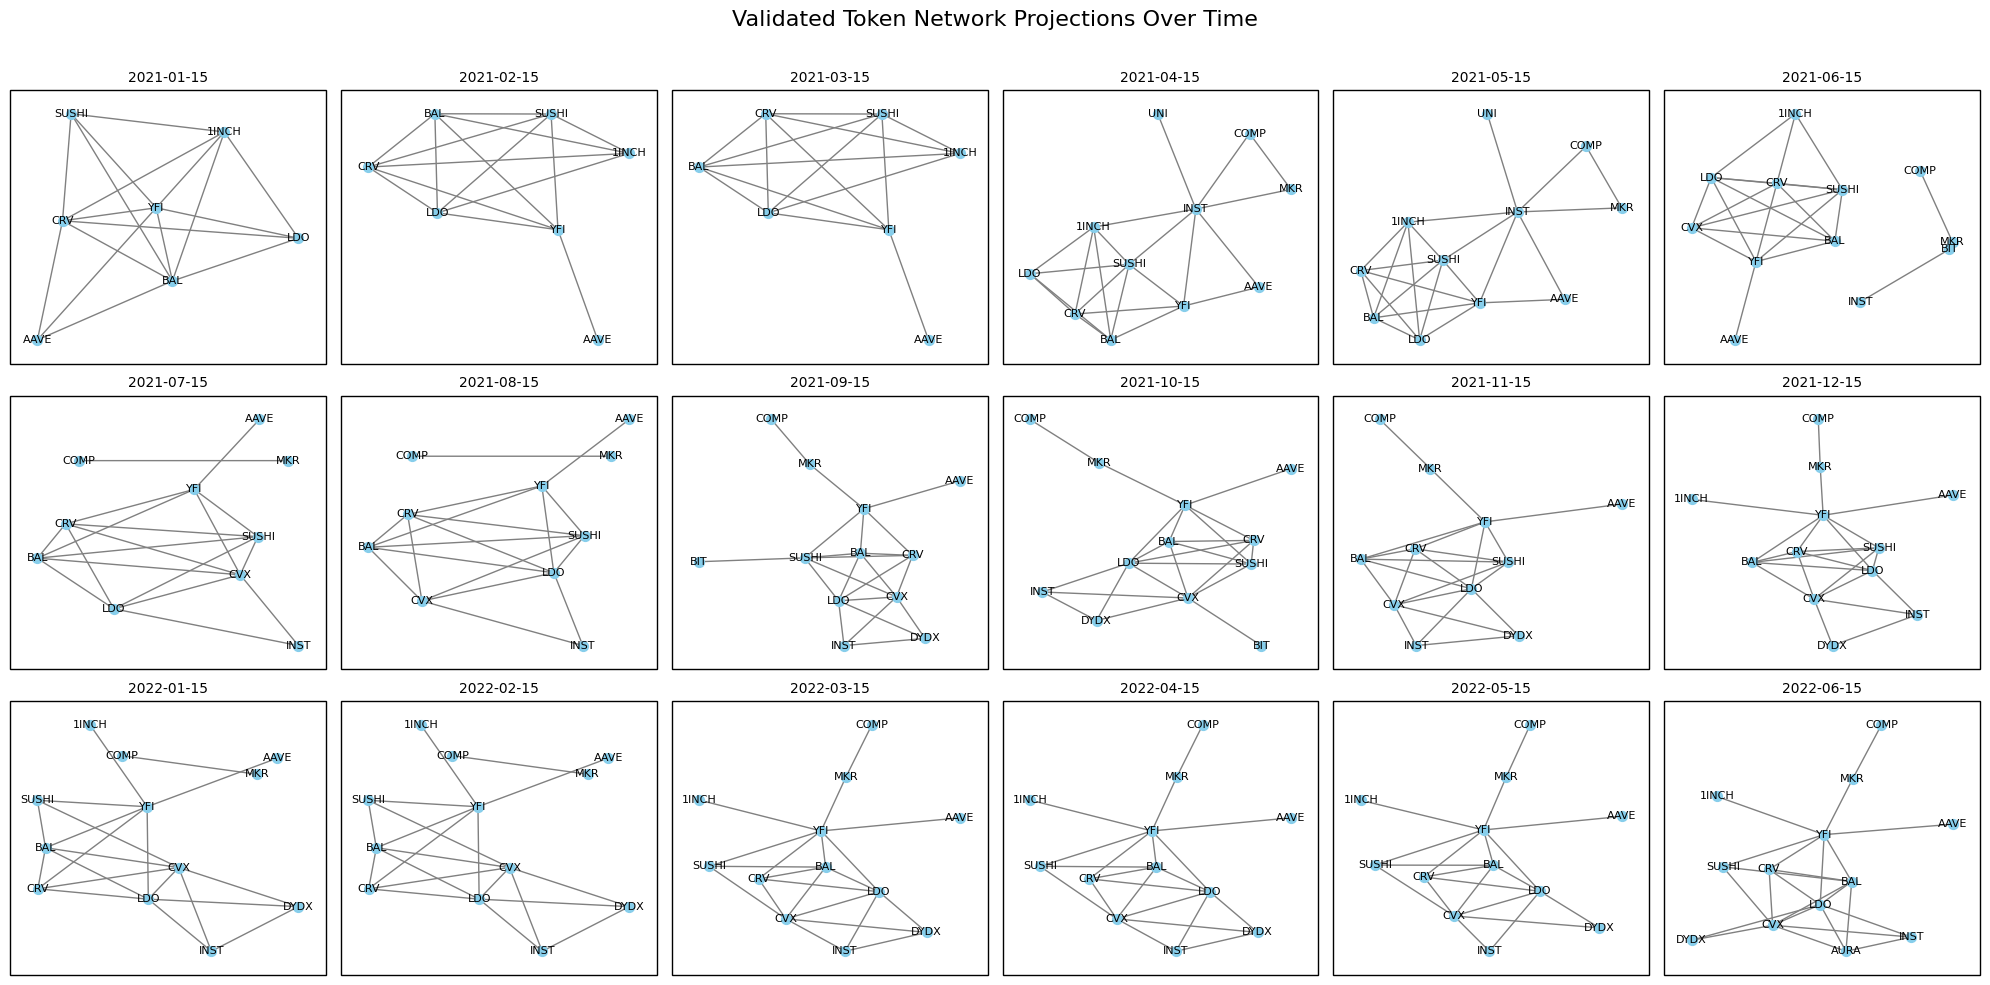

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd

visualize_network_grid(graphs, dates, address_to_symbol, output_directory='../output/token_network_projections/', layout=nx.kamada_kawai_layout)


## Jaccard Similarity of Validated Network Projection over time 

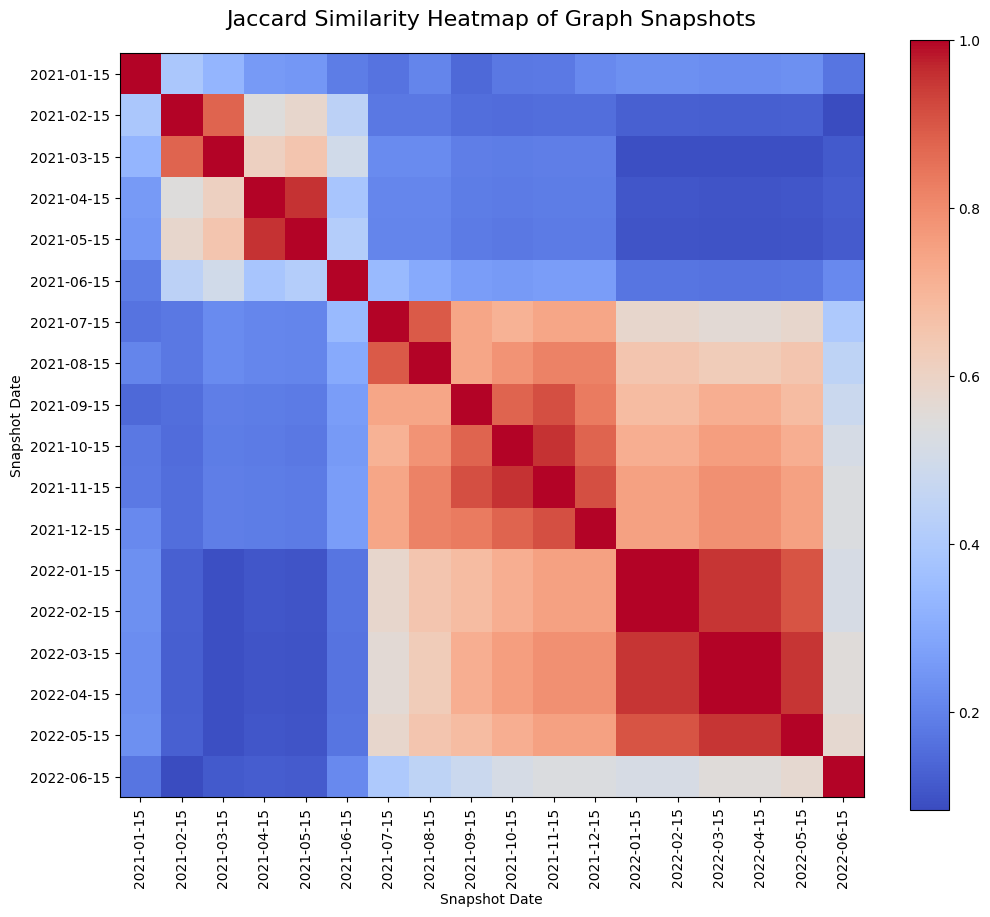

In [5]:
similarity_matrix, snapshot_list = calculate_similarity_matrix(graphs)

plot_similarity_heatmap(similarity_matrix, snapshot_list, dates, output_directory='../output/token_network_projections/')

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_token_ownership_over_time(path, df_snapshots, df_tokens, known_burner_addresses):
    pct_addresses_holding_given_token = []
    
    # Filter relevant block heights
    relevant_snapshots = df_snapshots[df_snapshots['Block Height'] >= 11659570]['Block Height']
    
    for snapshot in relevant_snapshots:
        # Read the snapshot
        file_path = os.path.join(path, f"../data/snapshot_token_balance_tables/token_holder_snapshot_balance_{snapshot}.csv")
        ddf = pd.read_csv(file_path, index_col=[0])
        
        ddf = ddf[ddf.value > 0]  # Consider non-zero balances at snapshot

        # Calculate the total value for each token
        total_value_per_token = ddf.groupby('token_address').value.sum()

        # Calculate percentage of supply held
        ddf['pct_supply'] = ddf.apply(lambda x: x['value'] / total_value_per_token[x['token_address']], axis=1)

        # Filter to the latest tokens and exclude known burner addresses
        ddf.reset_index(inplace=True)
        ddf = ddf[ddf.token_address.isin(df_tokens.address)]
        ddf = ddf[~ddf.address.isin(known_burner_addresses)]
        
        # Calculate the fraction of addresses holding a significant amount of each token
        fractional_ownership = ddf.groupby('token_address').address.nunique() / ddf.address.nunique()
        pct_addresses_holding_given_token.append(fractional_ownership)

    # Concatenate the results across all snapshots
    df_token_fractional_ownership = pd.concat(pct_addresses_holding_given_token, axis=1, join='outer')
    df_token_fractional_ownership.columns = list(df_snapshots[df_snapshots['Block Height'] >= 11659570]['Date'])

    # Map token addresses to names and set as index
    token_name_dict = dict(zip(df_tokens['address'], df_tokens['name'])) 
    df_token_fractional_ownership['name'] = df_token_fractional_ownership.index.map(token_name_dict)
    df_token_fractional_ownership.set_index('name', inplace=True)
    
    # Plotting
    ax = df_token_fractional_ownership.T.plot(kind='line', figsize=(10, 6))
    plt.xlabel('Date')
    plt.ylabel('Fraction of Wallets Holding')
    plt.title('Fraction of Wallets Holding a Given Token Over Time')
    plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Example usage assuming you have defined df_snapshot, df_addresses, and known_burner_addresses
plot_token_ownership_over_time(path, df_snapshots, df_tokens, known_burner_addresses)


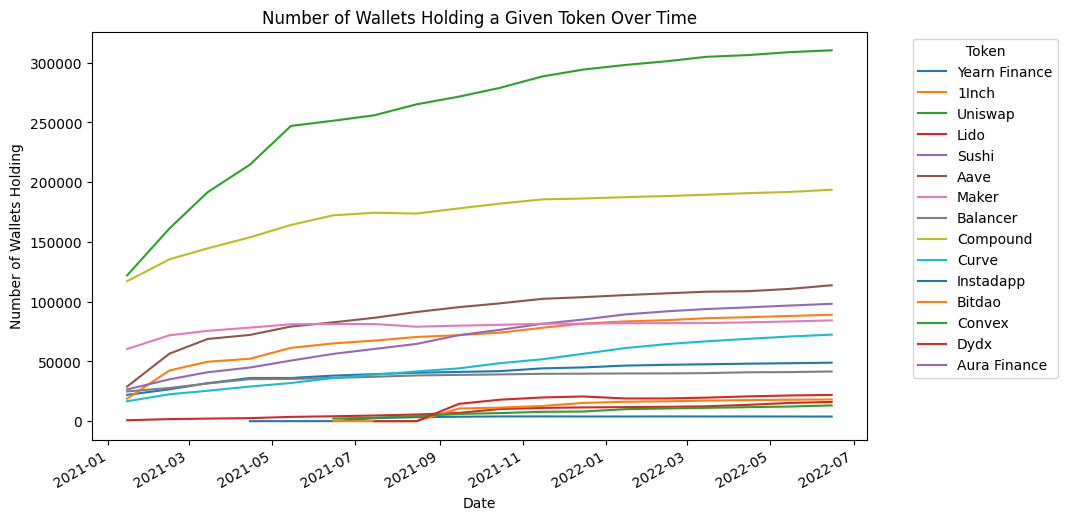

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_absolute_token_ownership_over_time(path, df_snapshots, df_tokens, known_burner_addresses):
    absolute_addresses_holding_given_token = []
    
    # Filter relevant block heights
    relevant_snapshots = df_snapshots[df_snapshots['Block Height'] >= 11659570]['Block Height']
    
    for snapshot in relevant_snapshots:
        # Read the snapshot
        file_path = os.path.join(path, f"../data/snapshot_token_balance_tables/token_holder_snapshot_balance_{snapshot}.csv")
        ddf = pd.read_csv(file_path, index_col=[0])
        
        ddf = ddf[ddf.value > 0]  # Consider non-zero balances at snapshot

        # Filter to the latest tokens and exclude known burner addresses
        ddf.reset_index(inplace=True)
        ddf = ddf[ddf.token_address.isin(df_tokens.address)]
        ddf = ddf[~ddf.address.isin(known_burner_addresses)]
        
        # Calculate the absolute number of addresses holding each token
        absolute_ownership = ddf.groupby('token_address').address.nunique()
        absolute_addresses_holding_given_token.append(absolute_ownership)

    # Concatenate the results across all snapshots
    df_token_absolute_ownership = pd.concat(absolute_addresses_holding_given_token, axis=1, join='outer')
    df_token_absolute_ownership.columns = list(df_snapshots[df_snapshots['Block Height'] >= 11659570]['Date'])

    # Map token addresses to names and set as index
    token_name_dict = dict(zip(df_tokens['address'], df_tokens['name'])) 
    df_token_absolute_ownership['name'] = df_token_absolute_ownership.index.map(token_name_dict)
    df_token_absolute_ownership.set_index('name', inplace=True)
    
    # Plotting
    ax = df_token_absolute_ownership.T.plot(kind='line', figsize=(10, 6))
    plt.xlabel('Date')
    plt.ylabel('Number of Wallets Holding')
    plt.title('Number of Wallets Holding a Given Token Over Time')
    plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Example usage assuming you have defined df_snapshot, df_addresses, and known_burner_addresses
plot_absolute_token_ownership_over_time(path, df_snapshots, df_tokens, known_burner_addresses)
